In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import lightgbm
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

In [2]:
dir = ""

In [3]:
wl_odds_player_df = pd.read_csv(dir + "wl_odds_player_df.csv")

wl_odds_player_df = wl_odds_player_df.drop('Unnamed: 0', axis=1)

In [4]:
wl_odds_player_df.columns

Index(['league_id', 'season', 'date', 'stage', 'match_id', 'team_id',
       'm_rating', 'win', 'lose', 'rating_diff', 'home', 'cumulative_win',
       'cumulative_lose', 'match_num', 'match_bin', 'draw',
       'avg_overall_rating', 'avg_volleys_imp', 'avg_long_passing',
       'avg_finishing', 'avg_ball_control', 'avg_dribbling',
       'avg_short_passing', 'avg_reactions', 'avg_vision_imp', 'avg_penalties',
       'avg_agility_imp', 'result', 'cumulative_result'],
      dtype='object')

In [5]:
seasons = sorted(wl_odds_player_df["season"].unique())

In [6]:
for i in range(1, len(seasons)-1):
    print(seasons[i:i+2])

['2009/2010', '2010/2011']
['2010/2011', '2011/2012']
['2011/2012', '2012/2013']
['2012/2013', '2013/2014']
['2013/2014', '2014/2015']
['2014/2015', '2015/2016']


# Training period 1 season

In [6]:
ll_01 = list()

for i in range(1, len(seasons)-1):
    
    train_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin(seasons[i:i+2][:-1])].dropna()
    test_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin([seasons[i:i+2][-1]])].dropna()

    train_dates = sorted(train_df["date"].unique())

    calib_dates = random.sample(train_dates, int(len(train_dates)*0.25))

    calib_df = train_df.loc[train_df["date"].isin(calib_dates)]

    train_df = train_df.loc[~train_df["date"].isin(calib_dates)]

    feat_col = [c for c in train_df.columns if "avg" in c]
    feat_col = feat_col + ["rating_diff"]

    skf = StratifiedKFold(n_splits=6, shuffle=True)

    lgb_param_grid = {'lgb__n_estimators': [100, 200, 300,],
                     'lgb__num_leaves':  [2, 4, 6, 10, 15, 20],
                     'lgb__subsample': [0.4, 0.6, 0.8, 1],
                     'lgb__colsample_bytree': [0.4, 0.6, 0.8, 1],
                     'lgb__is_unbalance': [False]}

    lgb_pipe = Pipeline([("lgb", lightgbm.LGBMClassifier())])

    lgb_cv = RandomizedSearchCV(lgb_pipe, 
                                param_distributions=lgb_param_grid, 
                                n_jobs=-1,
                                cv=skf, 
                                     n_iter=50,
                                     refit=True,
                                    )

    lgb_cv.fit(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                              "cumulative_lose", "cumulative_win",
                              "season", "date", "stage", "match_id", 'match_num'], axis=1),
                    train_df["win"])


    lgb_calib = CalibratedClassifierCV(lgb_cv, method='sigmoid', cv=5)

    lgb_calib.fit(calib_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                 "cumulative_lose", "cumulative_win",
                                 "season", "date", "stage", "match_id", 'match_num'], axis=1),
                  calib_df["win"])

    lgb_calib_pred = lgb_calib.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                           "cumulative_lose", "cumulative_win",
                                                           "season", "date", "stage", "match_id", 'match_num'], axis=1))

    ll_01.append(log_loss(test_df["win"], lgb_calib_pred))



# Training period 2 season

In [14]:
for i in range(1, len(seasons)-2):
    print(seasons[i:i+3])


['2009/2010', '2010/2011', '2011/2012']
['2010/2011', '2011/2012', '2012/2013']
['2011/2012', '2012/2013', '2013/2014']
['2012/2013', '2013/2014', '2014/2015']
['2013/2014', '2014/2015', '2015/2016']


In [7]:
ll_02 = list()

for i in range(1, len(seasons)-2):
    
    train_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin(seasons[i:i+3][:-1])].dropna()
    test_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin([seasons[i:i+3][-1]])].dropna()

    train_dates = sorted(train_df["date"].unique())

    calib_dates = random.sample(train_dates, int(len(train_dates)*0.25))

    calib_df = train_df.loc[train_df["date"].isin(calib_dates)]

    train_df = train_df.loc[~train_df["date"].isin(calib_dates)]

    feat_col = [c for c in train_df.columns if "avg" in c]
    feat_col = feat_col + ["rating_diff"]

    skf = StratifiedKFold(n_splits=6, shuffle=True)

    lgb_param_grid = {'lgb__n_estimators': [100, 200, 300,],
                     'lgb__num_leaves':  [2, 4, 6, 10, 15, 20],
                     'lgb__subsample': [0.4, 0.6, 0.8, 1],
                     'lgb__colsample_bytree': [0.4, 0.6, 0.8, 1],
                     'lgb__is_unbalance': [False]}

    lgb_pipe = Pipeline([("lgb", lightgbm.LGBMClassifier())])

    lgb_cv = RandomizedSearchCV(lgb_pipe, 
                                param_distributions=lgb_param_grid, 
                                n_jobs=-1,
                                cv=skf, 
                                     n_iter=50,
                                     refit=True,
                                    )

    lgb_cv.fit(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                              "cumulative_lose", "cumulative_win",
                              "season", "date", "stage", "match_id", 'match_num'], axis=1),
                    train_df["win"])


    lgb_calib = CalibratedClassifierCV(lgb_cv, method='sigmoid', cv=5)

    lgb_calib.fit(calib_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                 "cumulative_lose", "cumulative_win",
                                 "season", "date", "stage", "match_id", 'match_num'], axis=1),
                  calib_df["win"])

    lgb_calib_pred = lgb_calib.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                           "cumulative_lose", "cumulative_win",
                                                           "season", "date", "stage", "match_id", 'match_num'], axis=1))

    ll_02.append(log_loss(test_df["win"], lgb_calib_pred))


In [15]:
for i in range(1, len(seasons)-3):
    print(seasons[i:i+4])

['2009/2010', '2010/2011', '2011/2012', '2012/2013']
['2010/2011', '2011/2012', '2012/2013', '2013/2014']
['2011/2012', '2012/2013', '2013/2014', '2014/2015']
['2012/2013', '2013/2014', '2014/2015', '2015/2016']


# Training period 3 seasons

In [8]:
ll_03 = list()

for i in range(1, len(seasons)-3):
    
    train_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin(seasons[i:i+4][:-1])].dropna()
    test_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin([seasons[i:i+4][-1]])].dropna()

    train_dates = sorted(train_df["date"].unique())

    calib_dates = random.sample(train_dates, int(len(train_dates)*0.25))

    calib_df = train_df.loc[train_df["date"].isin(calib_dates)]

    train_df = train_df.loc[~train_df["date"].isin(calib_dates)]

    feat_col = [c for c in train_df.columns if "avg" in c]
    feat_col = feat_col + ["rating_diff"]

    skf = StratifiedKFold(n_splits=6, shuffle=True)

    lgb_param_grid = {'lgb__n_estimators': [100, 200, 300,],
                     'lgb__num_leaves':  [2, 4, 6, 10, 15, 20],
                     'lgb__subsample': [0.4, 0.6, 0.8, 1],
                     'lgb__colsample_bytree': [0.4, 0.6, 0.8, 1],
                     'lgb__is_unbalance': [False]}

    lgb_pipe = Pipeline([("lgb", lightgbm.LGBMClassifier())])

    lgb_cv = RandomizedSearchCV(lgb_pipe, 
                                param_distributions=lgb_param_grid, 
                                n_jobs=-1,
                                cv=skf, 
                                     n_iter=50,
                                     refit=True,
                                    )

    lgb_cv.fit(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                              "cumulative_lose", "cumulative_win",
                              "season", "date", "stage", "match_id", 'match_num'], axis=1),
                    train_df["win"])


    lgb_calib = CalibratedClassifierCV(lgb_cv, method='sigmoid', cv=5)

    lgb_calib.fit(calib_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                 "cumulative_lose", "cumulative_win",
                                 "season", "date", "stage", "match_id", 'match_num'], axis=1),
                  calib_df["win"])

    lgb_calib_pred = lgb_calib.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                           "cumulative_lose", "cumulative_win",
                                                           "season", "date", "stage", "match_id", 'match_num'], axis=1))

    ll_03.append(log_loss(test_df["win"], lgb_calib_pred))



In [12]:
np.mean(ll_01), np.mean(ll_02), np.mean(ll_03)

(0.595399931445676, 0.590084907734808, 0.5886806763778378)

# Training period 3 seasons with current season

In [9]:
ll_04 = list()

for i in range(1, len(seasons)-3):
    
    train_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin(seasons[i:i+4][:-1])].dropna()
    test_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin([seasons[i:i+4][-1]])].dropna()
    
    test_dates = sorted(test_df["date"].unique())
    n = len(test_dates) // 2

    train_df = pd.concat([train_df, 
                          test_df.loc[test_df["date"].isin(test_dates[:n])]])

    test_df = test_df.loc[test_df["date"].isin(test_dates[n:])]

    train_dates = sorted(train_df["date"].unique())

    calib_dates = random.sample(train_dates, int(len(train_dates)*0.25))

    calib_df = train_df.loc[train_df["date"].isin(calib_dates)]

    train_df = train_df.loc[~train_df["date"].isin(calib_dates)]

    feat_col = [c for c in train_df.columns if "avg" in c]
    feat_col = feat_col + ["rating_diff"]


    skf = StratifiedKFold(n_splits=6, shuffle=True)

    lgb_param_grid = {'lgb__n_estimators': [100, 200, 300,],
                     'lgb__num_leaves':  [2, 4, 6, 10, 15, 20],
                     'lgb__subsample': [0.4, 0.6, 0.8, 1],
                     'lgb__colsample_bytree': [0.4, 0.6, 0.8, 1],
                     'lgb__is_unbalance': [False]}

    lgb_pipe = Pipeline([("lgb", lightgbm.LGBMClassifier())])

    lgb_cv = RandomizedSearchCV(lgb_pipe, 
                                param_distributions=lgb_param_grid, 
                                n_jobs=-1,
                                cv=skf, 
                                     n_iter=50,
                                     refit=True,
                                    )

    lgb_cv.fit(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                              "cumulative_lose", "cumulative_win",
                              "season", "date", "stage", "match_id", 'match_num'], axis=1),
                    train_df["win"])


    lgb_calib = CalibratedClassifierCV(lgb_cv, method='sigmoid', cv=5)

    lgb_calib.fit(calib_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                 "cumulative_lose", "cumulative_win",
                                 "season", "date", "stage", "match_id", 'match_num'], axis=1),
                  calib_df["win"])

    lgb_calib_pred = lgb_calib.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                           "cumulative_lose", "cumulative_win",
                                                           "season", "date", "stage", "match_id", 'match_num'], axis=1))

    ll_04.append(log_loss(test_df["win"], lgb_calib_pred))



In [10]:
ll_05 = list()

for i in range(1, len(seasons)-3):
    
    train_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin(seasons[i:i+4][:-1])].dropna()
    test_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin([seasons[i:i+4][-1]])].dropna()
    
    test_dates = sorted(test_df["date"].unique())
    n = len(test_dates) // 2

    #train_df = pd.concat([train_df, 
    #                      test_df.loc[test_df["date"].isin(test_dates[:n])]])

    test_df = test_df.loc[test_df["date"].isin(test_dates[n:])]

    train_dates = sorted(train_df["date"].unique())

    calib_dates = random.sample(train_dates, int(len(train_dates)*0.25))

    calib_df = train_df.loc[train_df["date"].isin(calib_dates)]

    train_df = train_df.loc[~train_df["date"].isin(calib_dates)]

    feat_col = [c for c in train_df.columns if "avg" in c]
    feat_col = feat_col + ["rating_diff"]


    skf = StratifiedKFold(n_splits=6, shuffle=True)

    lgb_param_grid = {'lgb__n_estimators': [100, 200, 300,],
                     'lgb__num_leaves':  [2, 4, 6, 10, 15, 20],
                     'lgb__subsample': [0.4, 0.6, 0.8, 1],
                     'lgb__colsample_bytree': [0.4, 0.6, 0.8, 1],
                     'lgb__is_unbalance': [False]}

    lgb_pipe = Pipeline([("lgb", lightgbm.LGBMClassifier())])

    lgb_cv = RandomizedSearchCV(lgb_pipe, 
                                param_distributions=lgb_param_grid, 
                                n_jobs=-1,
                                cv=skf, 
                                     n_iter=50,
                                     refit=True,
                                    )

    lgb_cv.fit(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                              "cumulative_lose", "cumulative_win",
                              "season", "date", "stage", "match_id", 'match_num'], axis=1),
                    train_df["win"])


    lgb_calib = CalibratedClassifierCV(lgb_cv, method='sigmoid', cv=5)

    lgb_calib.fit(calib_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                 "cumulative_lose", "cumulative_win",
                                 "season", "date", "stage", "match_id", 'match_num'], axis=1),
                  calib_df["win"])

    lgb_calib_pred = lgb_calib.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                           "cumulative_lose", "cumulative_win",
                                                           "season", "date", "stage", "match_id", 'match_num'], axis=1))

    ll_05.append(log_loss(test_df["win"], lgb_calib_pred))





In [11]:
np.mean(ll_04), np.mean(ll_05)

(0.5836123186733118, 0.5829456665238759)

In [17]:
from sklearn.calibration import calibration_curve

In [57]:
i = 2
    
train_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin(seasons[i:i+4][:-1])].dropna()
test_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin([seasons[i:i+4][-1]])].dropna()

test_dates = sorted(test_df["date"].unique())
n = len(test_dates) // 2

train_df = pd.concat([train_df, 
                      test_df.loc[test_df["date"].isin(test_dates[:n])]])

test_df = test_df.loc[test_df["date"].isin(test_dates[n:])]

train_dates = sorted(train_df["date"].unique())

calib_dates = random.sample(train_dates, int(len(train_dates)*0.25))

calib_df = train_df.loc[train_df["date"].isin(calib_dates)]

train_df = train_df.loc[~train_df["date"].isin(calib_dates)]

feat_col = [c for c in train_df.columns if "avg" in c]
feat_col = feat_col + ["rating_diff"]


skf = StratifiedKFold(n_splits=6, shuffle=True)

lgb_param_grid = {'lgb__n_estimators': [100, 200, 300,],
                 'lgb__num_leaves':  [2, 4, 6, 10, 15, 20],
                 'lgb__subsample': [0.4, 0.6, 0.8, 1],
                 'lgb__colsample_bytree': [0.4, 0.6, 0.8, 1],
                 'lgb__is_unbalance': [False]}

lgb_pipe = Pipeline([("lgb", lightgbm.LGBMClassifier())])

lgb_cv = RandomizedSearchCV(lgb_pipe, 
                            param_distributions=lgb_param_grid, 
                            n_jobs=-1,
                            cv=skf, 
                                 n_iter=50,
                                 refit=True,
                                )

lgb_cv.fit(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                          "cumulative_lose", "cumulative_win",
                          "season", "date", "stage", "match_id", 'match_num'], axis=1),
                train_df["win"])


lgb_calib = CalibratedClassifierCV(lgb_cv, method='sigmoid', cv=5)

lgb_calib.fit(calib_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                             "cumulative_lose", "cumulative_win",
                             "season", "date", "stage", "match_id", 'match_num'], axis=1),
              calib_df["win"])

lgb_calib_pred = lgb_calib.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                       "cumulative_lose", "cumulative_win",
                                                       "season", "date", "stage", "match_id", 'match_num'], axis=1))






In [58]:
lgb_og_pred = lgb_cv.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                    "cumulative_lose", "cumulative_win",
                                                    "season", "date", "stage", "match_id", 'match_num'], axis=1))

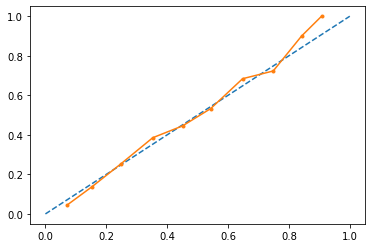

In [59]:
fop, mpv = calibration_curve(test_df["win"], lgb_og_pred[:,1], n_bins=10)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

In [60]:
lgb_calib_pred = lgb_calib.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                    "cumulative_lose", "cumulative_win",
                                                    "season", "date", "stage", "match_id", 'match_num'], axis=1))

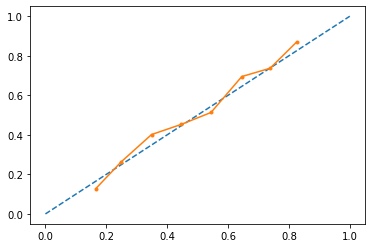

In [61]:
fop, mpv = calibration_curve(test_df["win"], lgb_calib_pred[:,1], n_bins=10)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()